# Predicting SBAC
by Amee Tan 

Table of Contents 
----
1. Research Question
2. Evaluation Metrics
3. Clean data, transform target into binary classes, ensure consistent class ratios among train and test set
4. Search for best algorithms
5. Tune hyperparameters for 3 candidate models
6. Compare 3 candidate models and select final model
7. Examine feature importances for the final model and remove features to simplify model
8. Run final model on test set 
9. Conclusion and next steps 

Research Questions 
----
1. Can we use student demographic information and test scores throughout the year to predict whether or not a student will pass the Math SBAC at the end of the year? 
2. Which features are most important for the models' predictions? 


Evaluation Metrics  
----
2 evaluation metrics are used in this notebook: precision & accuracy 

**Precision:** 
- Since the goal is to produce a model that reduces false positives, precision is the best way to measure the model's performance.
- A false positive means the model predicts that a student will pass SBAC when in reality they fail. This is problematic because it means there are students who should have received extra support during the school year did not receive it because the model did not identify them as being on track to fail.

**Accuracy:** 
- It is also important to know the overall accuracy of the model. Given that the target class had a 66/34 split, it is important to make sure the model outperforms the a priori probability (meaning the model needs to achieve an accuracy score of 0.66 or higher)
- I debated whether to use accuracy or balanced accuracy. Balanced accuracy is better when there are class imbalances, but since the target had about a 66/34 split between the two classes, I decided this was not enough of a class imbalance to merit using balanced accuracy. Furthermore, balanced accuracy is defined as the average of recall obtained on each class. Recall is not as important for this case, so I stuck with accuracy score as my second metric.

In [27]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from   sklearn.base            import BaseEstimator
from   sklearn.compose         import *
from   sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier, IsolationForest, GradientBoostingClassifier
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from   sklearn.inspection      import permutation_importance
from   sklearn.linear_model    import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from   sklearn.metrics         import precision_score, classification_report, accuracy_score, confusion_matrix
from   sklearn.model_selection import cross_validate, cross_val_score, KFold, RandomizedSearchCV, train_test_split
from   sklearn.neighbors       import *
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import *
from   sklearn.svm             import SVC
from   sklearn.tree            import DecisionTreeClassifier, ExtraTreeClassifier

import warnings
warnings.filterwarnings("ignore")

Load Data
-----
Due to FERPA guidelines around student privacy, I joined the two dataframes on student name, then removed the student name, student ID number, and school name columns before uploading the dataset to be viewed publically. 

In [3]:
data = pd.read_csv('https://github.com/amtan20/predictSBAC/raw/main/public_student_data.csv')

In [4]:
# Create X and y dataframes 
X = data.drop(columns=['Mathematics Achievement Level','ELA/Literacy Achievement Level'])
y = data['Mathematics Achievement Level']

In [5]:
# Clean up column names 

X.rename(columns={"Reading Fall '18 %ile" : "Reading Fall Percentile", 
                  "Reading Winter '18 %ile" : "Reading Winter Percentile", 
                  "Math Fall '18 %ile" : "Math Fall Percentile", 
                  "Winter '18 %ile" : "Math Winter Percentile",
                  "Reading \nMet Winter Goal?" : "Reading Met Winter Goal?"}, inplace=True)

Create Binary Target 
-----
The data in the target column originally has 4 levels:
- Standard Not Met (Fail)
- Standard Nearly Met (Fail)
- Standard Met (Pass)
- Standard Exceeded (Pass)

For this project, I was more interested in determining if a student would pass or fail because this binary classification is more important for teachers than the multi-class classification. The first two levels indicate that a student failed. The last two levels indicate that a student passed. 

In [6]:
# Change y into binary numeric target 
def create_binary_target(y):
    return np.where(y=='Standard Not Met',0, np.where(y=='Standard Nearly Met', 0, 1))

In [7]:
# Use FunctionTransformer to apply the function to the target 
transformer = FunctionTransformer(create_binary_target)
y = transformer.transform(y)

Create Train, Validation, and Test Sets 
-----
There is a 68/32 split in the target class, so I wanted to make sure this ratio was preserved in the train and test set. To do this, I added in the stratefy argument to train_test_split. 

In [8]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=46)


In [9]:
X_train.to_csv('X_train.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')

Build Pipeline 
----
Impute missing values, one hot encode categorical features, and standardize numeric features 

I selected 23 initial features to put in the model using my domain knowledge. There were some features that offer duplicate information, such as Math Fall Score and Math Fall Percentile. In those cases, I kept the percentile columns because a student's percentile is more useful for teachers than a student's raw score. There were also many features that have the potential to leak target information because they all represent how a student did on certain sub-sections of the SBAC - these were all excluded from the model. 

In [10]:
boolean_columns = ['IDEA Indicator', 'LEP Status', 'Economically Disadvantaged Status']

categorical_columns = ['Grade _x', 
       'Reading Met Winter Goal?', 
       'Math Met Winter Goal?', 
       'Race/Ethnicity', 'Language Code',
       'English Language Proficiency Level', 'Migrant Status',
       'Primary Disability Type']

numeric_columns = ['Reading Fall Percentile',
       'Reading Winter Percentile', 'Reading Fall Score to Winter Growth',
       'Math Fall Percentile',
       'Math Winter Percentile', 'Math Fall to Winter Growth',
       'Math Met Winter Goal?', 
       'First Entry Date Into US School', 'LEP Entry Date', 'LEP Exit Date']


boolean_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='False')), 
                         ('ohe', OneHotEncoder(handle_unknown='ignore'))])

categorical_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                             ('ohe', OneHotEncoder(handle_unknown='ignore'))])

numeric_pipe = Pipeline([('scaler', StandardScaler()),
                         ('imputer', SimpleImputer(strategy='median'))])

preprocessing = ColumnTransformer([('boolean', boolean_pipe,  boolean_columns),
                                   ('categorical', categorical_pipe, categorical_columns),
                                   ('numeric',  numeric_pipe, numeric_columns)])   

Search for best algorithms using randomized search cross validation
----
Since this is a classification problem, I wanted to do a standard Logistic Regression model. Additionally, I will my other 2 models using RandomizedSearchCV. Since RandomizedSearchCV returns a single best model, I will run it twice. 

In [18]:
# Create helper class 
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [84]:
# 1st iteration 

pipe = Pipeline([('preprocessing', preprocessing),
                 ('mod', DummyEstimator())])

models = [{'mod' : [ExtraTreesClassifier()]},
          {'mod' : [GradientBoostingClassifier()]},
          {'mod' : [KNeighborsClassifier()]},
          {'mod' : [LogisticRegression()]},
          {'mod' : [PassiveAggressiveClassifier()]},
          {'mod' : [RandomForestClassifier()]},
          {'mod' : [RidgeClassifier()]},
          {'mod' : [SGDClassifier()]},
          {'mod' : [SVC()]}
          ]

clf_rand = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=models, 
                              n_iter=5,
                              cv=5,
                              scoring='precision',
                              n_jobs=-1)
best_model = clf_rand.fit(X_train, y_train) 
best_model.best_estimator_


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('boolean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='False',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['IDEA Indicator',
                                                   'LEP Status',
                                                   'Economically Disadvantaged '
                                                   'Status']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                 

In [94]:
# 2nd iteration 

pipe = Pipeline([('preprocessing', preprocessing),
                 ('mod', DummyEstimator())])

clf_rand = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=models, 
                              n_iter=5,
                              cv=5,
                              scoring='precision',
                              n_jobs=-1)
best_model = clf_rand.fit(X_train, y_train) 
best_model.best_estimator_


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('boolean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='False',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['IDEA Indicator',
                                                   'LEP Status',
                                                   'Economically Disadvantaged '
                                                   'Status']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                 

Hyper Parameter Tuning and KFold Cross Validation for each candidate model
----
Now that I have my 3 candidate models, I will:
1. Do a randomized search with cross validation to find the best hyperparameters for each model. 
2. Run a KFold Cross Validation to get the precision and accuracy scores for the tuned models. I will get 10 precision and accuracy scores from the KFold Cross Validation and will take the mean. Taking the average of 10 scores will give me a more stable estimate of the performance of the model on the training set. 

### Model 1: Logistic Regression Classifier

In [47]:
# Search for hyperparameters 

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  LogisticRegression())])

search_space = {'classifier__C': np.logspace(0, 4, 10),
                'classifier__class_weight': [None,'balanced'],
                'classifier__dual': [True,False],
                'classifier__fit_intercept': [True,False],
                'classifier__max_iter': [10, 100, 500],
                'classifier__multi_class': ['auto', 'ovr', 'multinomial'],
                'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
                'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

clf_rand = RandomizedSearchCV(estimator=pipe, 
                            param_distributions=search_space, 
                            n_iter=5,
                            cv=5,
                            verbose=True)

clf_rand.fit(X_train, y_train)
clf_rand.best_estimator_.get_params()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.1s finished


{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('boolean',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='False',
                                                                   strategy='constant')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['IDEA Indicator', 'LEP Status',
                                     'Economically Disadvantaged Status']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ohe',
           

In [11]:
# Include only non-default params 
lr_best_params = {'C': 7.742636826811269,      # Larger value than default means there is less regularization
                  'class_weight': 'balanced',  # Uses values of y to adjust weights inversely proportional to class frequencies
                  'fit_intercept': False,      # No constant is added to the decision function
                  'max_iter': 500,             # Max number of iterations taken for the solver to converge 
                  'penalty': 'l1',             # L1 regularization pushes nonimportant coefficients to zero
                  'solver': 'liblinear'}       # Good choice for small datasets and handles the L1 penalty

In [12]:
# Establish kfold and scoring to be used for all 3 candidate models

kfold = KFold(n_splits=5, shuffle=True, random_state=46)

scoring = ['precision', 'accuracy']

In [14]:
# Fit model

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier', LogisticRegression(**lr_best_params))])

scores = cross_validate(pipe,
                        X_train,
                        y_train, 
                        cv=kfold, 
                        scoring=scoring)

lr_precision_score = scores['test_precision'].mean()
lr_acc_score = scores['test_accuracy'].mean()
print("Mean Logistic Regression Precision:", round(lr_precision_score,3))
print("Mean Logistic Regression Accuracy:", round(lr_acc_score,3))

Mean Logistic Regression Precision: 0.909
Mean Logistic Regression Accuracy: 0.837



### Model 2 : Extra Trees Classifier 


In [50]:
# Search for hyperparameters 

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  ExtraTreesClassifier())])

search_space = {'classifier__bootstrap': [False,True],
                'classifier__ccp_alpha': [0, 0.1, 0.01],
                'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
                'classifier__criterion': ['gini', 'entropy'],
                'classifier__max_features': ['auto','sqrt', 'log2'],
                'classifier__max_samples': [0.25,0.5, 0.75, None],
                'classifier__min_samples_leaf': [1,2,3],
                'classifier__min_samples_split': [2,3],
                'classifier__min_weight_fraction_leaf': [0.0, 0.1],
                'classifier__n_estimators': [10,100,500]}

clf_rand = RandomizedSearchCV(estimator=pipe, 
                            param_distributions=search_space, 
                            n_iter=5,
                            cv=5,
                            verbose=True,
                            )
clf_rand.fit(X_train, y_train)
clf_rand.best_estimator_.get_params()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    4.1s finished


{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('boolean',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='False',
                                                                   strategy='constant')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['IDEA Indicator', 'LEP Status',
                                     'Economically Disadvantaged Status']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ohe',
           

In [15]:
# Only include non-default params 

et_best_params = {'bootstrap': True,       # Use bootstrap samples to build the trees
                  'min_samples_leaf': 2,   # Min samples required in each leaf 
                  'min_samples_split': 3}  # Min samples required to split a node

In [16]:
# Fit model

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier', ExtraTreesClassifier(**et_best_params))])

scores = cross_validate(pipe,
                        X_train,
                        y_train, 
                        cv=kfold, 
                        scoring=scoring)

et_precision_score = scores['test_precision'].mean()
et_acc_score = scores['test_accuracy'].mean()
print("Mean Extra Trees Precision:", round(et_precision_score,3))
print("Mean Extra Trees Accuracy:", round(et_acc_score,3))


Mean Extra Trees Precision: 0.856
Mean Extra Trees Accuracy: 0.851


### Model 3: SGD Classifier 

In [53]:
# Search for hyperparameters 

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  SGDClassifier())])

search_space = {'classifier__alpha': [0.0001, 0.001, 0.01],
                 'classifier__class_weight': [None, 'balanced'],
                 'classifier__early_stopping': [True,False],
                 'classifier__fit_intercept': [True, False],
                 'classifier__l1_ratio': [0.05, 0.15, 0.25],
                 'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                 'classifier__max_iter': [1000, 2000],
                 'classifier__penalty': ['l2', 'l1', 'elasticnet']}

clf_rand = RandomizedSearchCV(estimator=pipe, 
                            param_distributions=search_space, 
                            n_iter=5,
                            cv=5,
                            verbose=True,
                            )
clf_rand.fit(X_train, y_train)
clf_rand.best_estimator_.get_params()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.7s finished


{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('boolean',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='False',
                                                                   strategy='constant')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['IDEA Indicator', 'LEP Status',
                                     'Economically Disadvantaged Status']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ohe',
           

In [17]:
# Include only those that are different from the default values 

sgd_best_params =  {'alpha': 0.01,          # Adds stronger regularizatino than the default value
                    'early_stopping': True, # Terminates training when validation score is not improving
                    'fit_intercept': False, # Set to false when data is already centered 
                    'max_iter': 2000,       # Maximum number of passes over the training data
                    'penalty': 'l1'}        # Regularization penalty 


In [18]:
# Fit model using KFold CV

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier', SGDClassifier(**sgd_best_params))])

scores = cross_validate(pipe,
                        X_train,
                        y_train, 
                        cv=kfold, 
                        scoring=scoring)

sgd_precision_score = scores['test_precision'].mean()
sgd_acc_score = scores['test_accuracy'].mean()
print("Mean SGD Precision:", round(sgd_precision_score,3))
print("Mean SGD Accuracy:", round(sgd_acc_score,3))


Mean SGD Precision: 0.851
Mean SGD Accuracy: 0.83


Summary of 3 Candidate Models 
----

In [19]:
pd.DataFrame({"Model": ["Logistic Regression", "Extra Trees", "SGD"], 
              "Precision": [lr_precision_score,et_precision_score,sgd_precision_score], 
              "Accuracy": [lr_acc_score,et_acc_score,sgd_acc_score]})\
            .round(3)\
            .sort_values(['Precision'], ascending=False)

,Model,Precision,Accuracy
0,Logistic Regression,0.909,0.837
1,Extra Trees,0.856,0.851
2,SGD,0.851,0.830


Since Logistic Regression had the highest precision and the 2nd highest accuracy, I willl select this as my final model. 

Examine Importances for Logistic Regression Model
----
Looking at the importances will help me:
   1. **Reduce the number of features in my model.** 
       - For logistic regression models, the simpler the model, the better because it will increase the generality of the model. I will use the results of the permutation importance to keep only the features that have positive non-zero importances. 
   2. **Gain a better understanding about which features are most important to the logistic regression model.** 
       - This will help me answer my second question about which features teachers should focus on that seem to be most important for predicting student performance. 

In [13]:
# Create train and validation set from original training set

X_train_imp, X_valid_imp, y_train_imp, y_valid_imp = train_test_split(X_train, y_train, random_state=46)

In [14]:
pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  LogisticRegression(**lr_best_params))])

model = pipe.fit(X_train_imp, y_train_imp)

r = permutation_importance(model, 
                           X_valid_imp, y_valid_imp,  
                           n_repeats=10,
                           random_state=42)

In [15]:
# Print results of importances 

features = X.columns
importances = r.importances_mean

feature_importances = []
for x in zip(features,importances):
    feature_importances.append((x[0], x[1]))

for x in sorted(feature_importances, key= lambda x: x[1], reverse=True):
    print(x[0], x[1])

Math Fall Percentile 0.12054794520547943
LEP Status 0.020547945205479423
English Language Proficiency Level 0.015068493150684892
Reading Fall Percentile 0.013698630136986278
Reading Fall Score to Winter Growth 0.009589041095890405
LEP Exit Date 0.0068493150684931225
Grade _x 0.004109589041095862
Reading Met Winter Goal? 0.004109589041095862
Reading Winter Percentile 0.0027397260273972377
LEP Entry Date 0.0013698630136986245
ID  0.0
Reading Fall '18 RIT 0.0
Reading Typical RIT Growth Points 0.0
Reading Tiered RIT Growth Points 0.0
Reading Winter '18 GOAL Score 0.0
Reading Winter '18 RIT 0.0
Reading Spring '19 GOAL Score 0.0
Reading Spring '19 RIT 0.0
Reading Spring '19 %ile 0.0
Reading Fall to Spring RIT Growth 0.0
Reading Met Spring Goal? 0.0
Math Fall '18 RIT 0.0
Math Typical RIT Growth Points 0.0
Math Tiered RIT Growth Points 0.0
Math Winter '18 GOAL Score 0.0
Math Winter '18 RIT 0.0
Math Spring '19 GOAL Score 0.0
Math Spring '19 RIT 0.0
Math Spring '19 %ile 0.0
Math Fall to Spring R

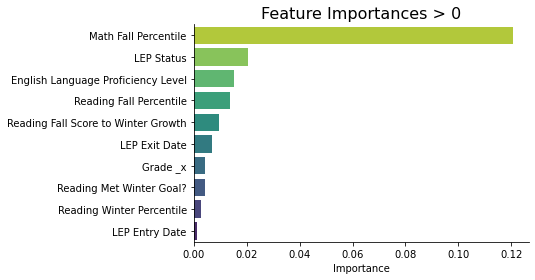

In [50]:
# Bar graph of feature importances 

sorted_features = sorted(feature_importances, reverse=True, key=lambda x : x[1])

sorted_names = [x[0] for x in sorted_features][:10]
sorted_scores = [x[1] for x in sorted_features][:10]

sns.barplot(sorted_scores, list(range(10)), orient='h', palette='viridis_r')
plt.yticks(ticks=range(10), labels=[sorted_names[i] for i in range(len(sorted_names))])
# plt.xlabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importances > 0', size=16)
sns.despine(top=True, right=True)
plt.show()

# Remove some codependent features and KFold CV again
- Math/Reading Fall Percentile and Winter Percentile are similar
    - Winter had negative importance and Fall had positive importance, so this is a sign I should keep just one
    - I will keep Winter since it shows the most recent information
- I will remove all features that had 0 or negative importance. 
- There are several features with extremely small importances. To keep the model simple, I will just keep the top 5. 
- The model originally had 23 features and now only has 5. 


In [43]:
# Columns in simplified model 
boolean_columns_2 = ['LEP Status']

categorical_columns_2 = ['English Language Proficiency Level']

numeric_columns_2 = ['Math Winter Percentile', 'Reading Winter Percentile', 'Reading Fall Score to Winter Growth']


preprocessing_2 = ColumnTransformer([('boolean', boolean_pipe,  boolean_columns_2),
                                     ('categorical', categorical_pipe, categorical_columns_2),
                                     ('numeric',  numeric_pipe, numeric_columns_2)])  

# Updated pipeline
pipe_2 = Pipeline([('preprocessing', preprocessing_2), 
                   ('classifier',  LogisticRegression(**lr_best_params))])

scores = cross_validate(pipe_2,
                        X_train,
                        y_train, 
                        cv=kfold, 
                        scoring=scoring)

lr_precision_score_2 = scores['test_precision'].mean()
lr_acc_score_2 = scores['test_accuracy'].mean()
print("Mean Logistic Regression Precision After Removing Features:", round(lr_precision_score_2,3))
print("Mean Logistic Regression Accuracy After Removing Features:", round(lr_acc_score_2,3))
print("")
print(f"Precision went from {round(lr_precision_score,3)} to {round(lr_precision_score_2,3)}, an improvement of", round(lr_precision_score_2 -lr_precision_score, 3))
print(f"Accuracy went from {round(lr_acc_score,3)} to {round(lr_acc_score_2,3)}, an improvement of", round(lr_acc_score_2 -lr_acc_score, 3))

Mean Logistic Regression Precision After Removing Features: 0.939
Mean Logistic Regression Accuracy After Removing Features: 0.872

Precision went from 0.909 to 0.939, an improvement of 0.03
Accuracy went from 0.876 to 0.872, an improvement of -0.004


Removing features increased the precision, but accuracy decreased

Final Model Results 
----
Now it is time to run the final pipeline on the test set!

In [ ]:
# Final Features
boolean_columns_final = ['LEP Status']

categorical_columns_final = ['English Language Proficiency Level']

numeric_columns_final = ['Math Winter Percentile', 'Reading Winter Percentile', 'Reading Fall Score to Winter Growth']


# Final Preprocessing Pipeline 
boolean_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='False')), 
                         ('ohe', OneHotEncoder(handle_unknown='ignore'))])

categorical_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                             ('ohe', OneHotEncoder(handle_unknown='ignore'))])

numeric_pipe = Pipeline([('scaler', StandardScaler()),
                         ('imputer', SimpleImputer(strategy='median'))])

preprocessing_final = ColumnTransformer([('boolean', boolean_pipe,  boolean_columns_final),
                                   ('categorical', categorical_pipe, categorical_columns_final),
                                   ('numeric',  numeric_pipe, numeric_columns_final)])  


# Hyperparameters
lr_best_params = {'C': 7.742636826811269,
                  'class_weight': 'balanced',
                  'fit_intercept': False,
                  'max_iter': 500,
                  'penalty': 'l1',
                  'solver': 'liblinear'}

# Final Pipeline
pipe_final = Pipeline([('preprocessing', preprocessing_final), 
                       ('classifier',  LogisticRegression(**lr_best_params))])

# Fit Pipeline on entire train 
pipe_final.fit(X_train, y_train)

# Predict on test set
preds = pipe_final.predict(X_test)

# See test set precision, accuraacy and confusion matrix 
lr_test_precision_score = precision_score(y_test, preds)
lr_test_acc_score = accuracy_score(y_test, preds)
lr_test_confusion = confusion_matrix(y_test, preds)

print("Logistic Regression Test Set Precision:", round(lr_test_precision_score,3))
print("Logistic Regression Test Set Accuracy:", round(lr_test_acc_score,3))
print("")
print("Test Set Confusion Matrix:")
print(lr_test_confusion)


In [46]:
# Create df to interpret confusion matrix 
labels = ['Fail', 'Pass']
pd.DataFrame(lr_test_confusion, columns=[f'Pred: {label}' for label in labels],
                  index=[f'Actual: {label}' for label in labels])


,Pred: Fail,Pred: Pass
Actual: Fail,26,5
Actual: Pass,7,59


There were 5 false positives - 5 students were predicted to pass who in reality failed. This is what I was trying to minimize. There were 7 false positives - y students were predicted to fail who in reality passed. 

In [47]:
# Check classification report 
full_report = classification_report(y_test, preds)
print(full_report)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81        31
           1       0.92      0.89      0.91        66

    accuracy                           0.88        97
   macro avg       0.85      0.87      0.86        97
weighted avg       0.88      0.88      0.88        97



It is interesting that the model has high precision for class 1 but low precision for class 0. Recall for both classes is about the same. 

Conclusions
----

**The model performed similarly on the test set as the train set**
<br>The model had a precision of 0.939 on the train/validation set and a precision of 0.922 on the test set. The precision decreased only slightly, meaning the model has good generality. 

**The model minimizes false positives**
<br>My final logistic regression model does a good job of correctly predicting students who will pass the SBAC. The model was selected and tuned to minimize the chance of false positives. In the test set, only 5 students are predicted to pass when in reality they failed. This model can help teachers identify students that need extra support who would have otherwise gone unnoticed.

**The model's accuracy beats the a priori probability**
<br> The model's accuracy is 0.88, well above the a priori probability of 0.66. There is still room for improvement in the accuracy score.

**The feature that was most important to the model's predictions was Math Winter Percentile**
It is unsurprising that Math Winter Percentile (derived from the student's score on the MAP test) is the most important predictor for performance on SBAC. The magnitude of this importance was much larger than all other features. This score was 0.12 while the second most important feature was 0.02. Even though there was a drastic drop in importance after the first feature, I decided to keep the top 5 features in the final model, which included: Math Winter Percentile, LEP Status, English Language Proficiency Level, Reading Fall Score to Winter Growth, and Reading Winter Percentile. 

**Areas for improvement:**
- There is a big gap in the model's precision for class 0 (fail) and class 1 (pass). I would like to improve the model's ability to minimize false negatives. 
- Though minimizing false positives was more important than minimizing false negatives, it is still important to note that the model predicts that 7 students would fail when in reality they passed. The model incorrectly suggests that those 7 students should be receiving extra interventions. This is an issue because teachers would unnecessarily be increasing the load of students in need of extra support, taking away some of the resources from the students who need it most.




Next Steps
----
1. I'd be interested in re-doing this problem as a multi-class classification problem. The target class originally had 4 classes (Below Standard, Near Standard, Standard Met, and Standard Exceeded). I would be most interested in seeing how accurately I could predict which students would be in the Near Standard class. This would help teachers zoom in even more on the borderline students who could benefit from a little extra intervention. 
2. I would also like to try running this model using data only from Q2 and Q3 students. These are the students for which the outcomes tend to be less clear. I'd be curious to get data from multiple schools or multiple school years to see how the model performs. 